In [40]:
import torch
import torch.nn as nn

from PIL import Image
from torchvision import datasets, transforms

import glob
import matplotlib.pyplot as plt
import random

In [41]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 128

PATH = "../../../data/raw/VCoR/"
TRAIN_PATH = f"{PATH}/train"

In [42]:
# Transformación igual que en entrenamiento
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [43]:
class CarCNN(nn.Module):
    def __init__(self, num_classes):
        super(CarCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [44]:
train_dataset = datasets.ImageFolder(TRAIN_PATH, transform=transform)
model = CarCNN(num_classes=len(train_dataset.classes))
model.load_state_dict(torch.load("../trained/modelo_color.pt", map_location=DEVICE))
model.to(DEVICE)
model.eval()

CarCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=15, bias=True)
  )
)

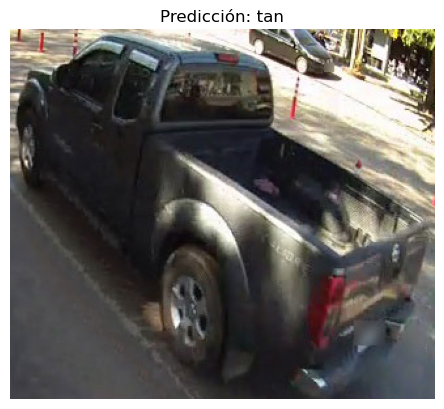

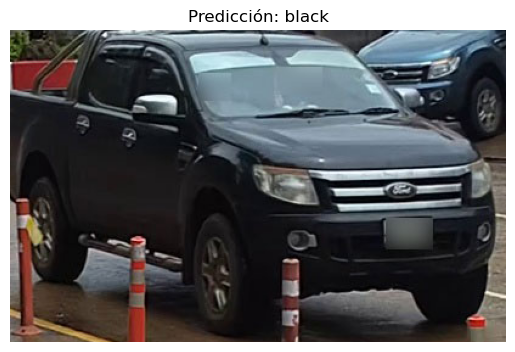

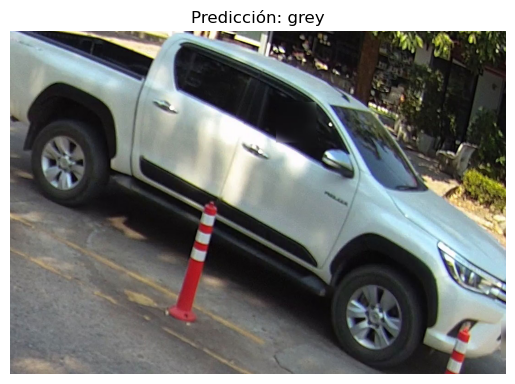

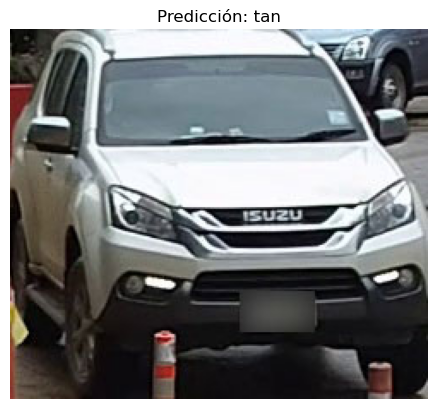

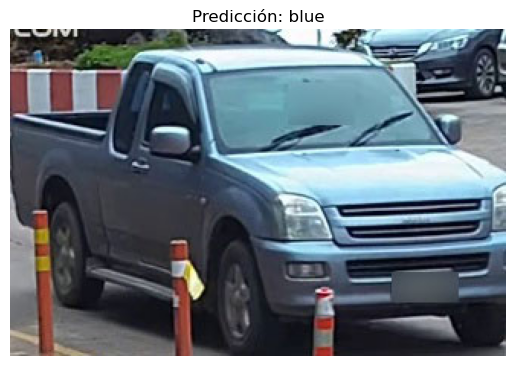

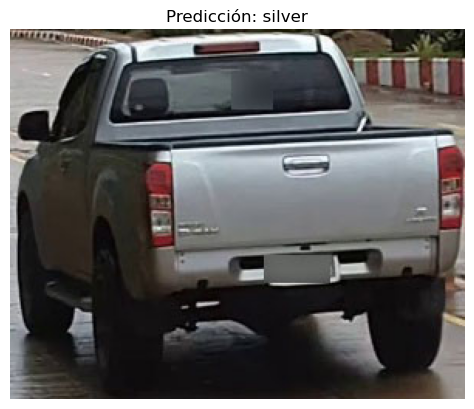

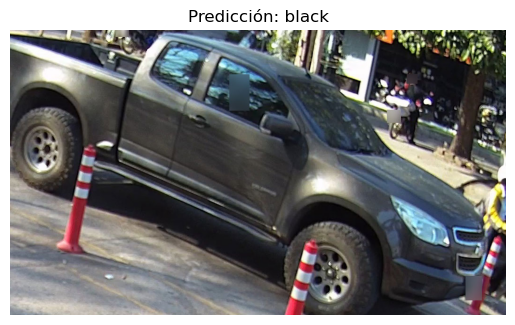

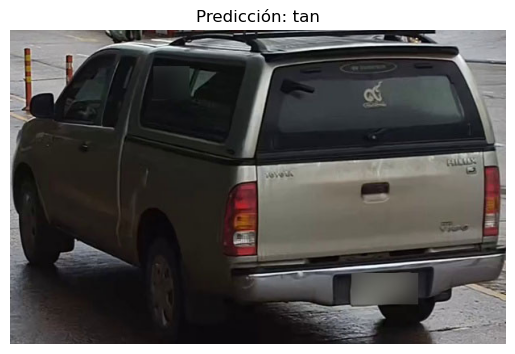

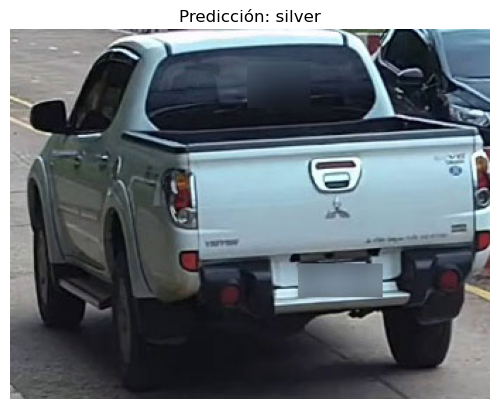

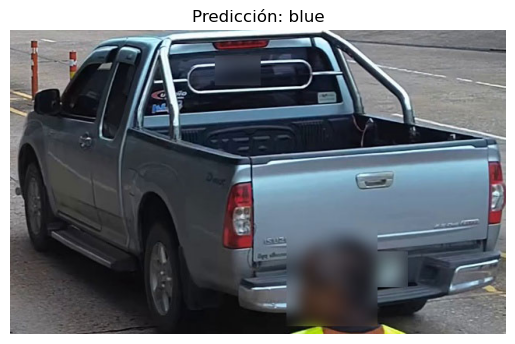

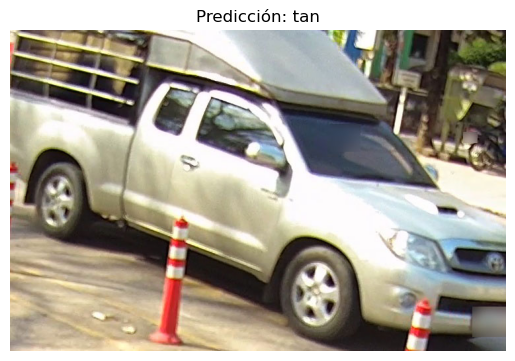

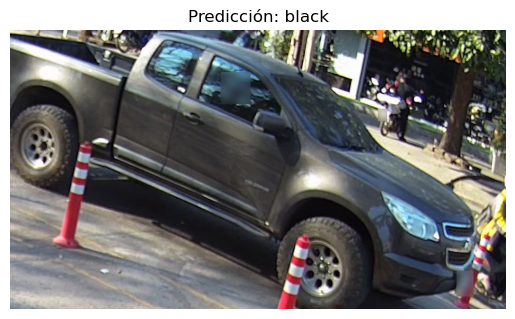

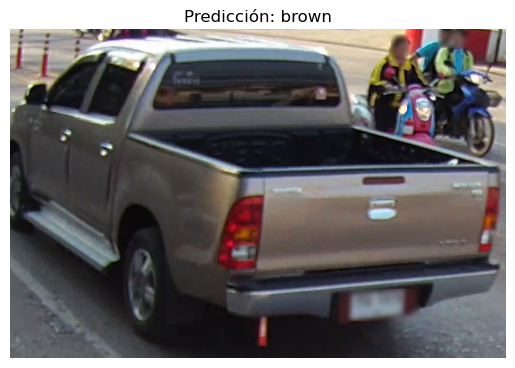

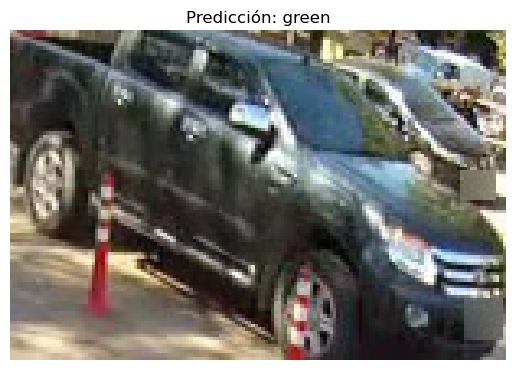

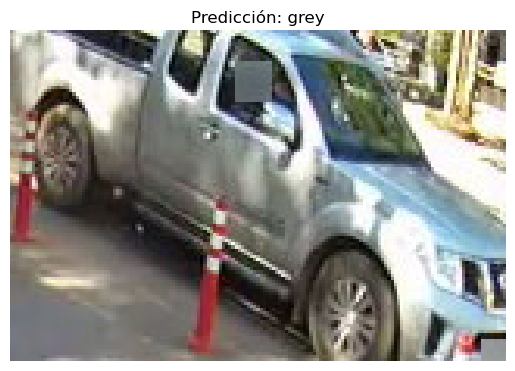

In [45]:
image_paths = glob.glob("./test_images/*")
sampled_paths = random.sample(image_paths, 15)
for img_path in sampled_paths:
    # Cargar y transformar imagen
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(DEVICE)  # batch de 1
    # Hacer predicción
    with torch.no_grad():
        output = model(img_tensor)
        _, pred_class = torch.max(output, 1)

    # Obtener nombre de la clase
    class_name = train_dataset.classes[pred_class.item()]
    plt.imshow(img)
    plt.title(f"Predicción: {class_name}")
    plt.axis("off")
    plt.show()